# **Deep Lerning Project : traffic sign recognition**





The aim of this collab notebook will be to use a convolutional neural network to recognise traffic sign (The dataset can be found on [kaggle](https://www.kaggle.com/datasets/shanmukh05/traffic-sign-cropped?select=test_labels.csv)). To this purpose, we will adapt the architecture of LeNet-5 (LeCun, 1989) to make our convolutional neural network.

## Setup

First, we set up our Google drive containing the dataset.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!unzip /content/drive/MyDrive/signs/archive.zip

In [ ]:
!pip install 'matplotlib == 3.5.1'

     |████████████████████████████████| 11.2 MB 6.0 MB/s 
     |████████████████████████████████| 899 kB 37.3 MB/s 
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.2.2
    Uninstalling matplotlib-3.2.2:
      Successfully uninstalled matplotlib-3.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [ ]:

from __future__ import print_function, division
import os
import torch.optim as optim
#import spacy
import tqdm
from collections import Counter
import random
import itertools

import warnings
from torchvision import transforms, utils
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import numpy as np
from skimage import io, transform
import pandas as pd
import torch
import torch.nn as nn
from sklearn.metrics import confusion_matrix
import seaborn as sns
import os
import pandas as pd
from torchvision.io import read_image
from sklearn.model_selection import train_test_split  
from torch.utils.data import DataLoader
import albumentations
import albumentations.pytorch
from torchvision import transforms
from IPython.display import IFrame


In [ ]:
import pandas as pd 
import numpy as np
import os
import torchvision
import itertools

First, we set up our Google drive containing the dataset.

In [ ]:
CLASSES = os.listdir('/content/crop_dataset/crop_dataset')


In [ ]:
img_labels = []
for clas in CLASSES:
  img_labels.append(os.listdir('/content/crop_dataset/crop_dataset/'+clas))
len(img_labels)

43

In [ ]:
img_label2 = []
for i in range(len(img_labels)):
  clas = [CLASSES[i]+'/' + sub for sub in img_labels[i]]
  img_label2.append(clas)

img_label2 = list(itertools.chain.from_iterable(img_label2))
image_label_df = pd.DataFrame(img_label2, columns = ['Image_path'])

With this vectorize function we'll extract each class name each from folder name

In [ ]:
def return35_str(txt):
  return(int(txt[3:5]))

return35_vec = np.vectorize(return35_str)

In [ ]:
image_label_df['Image_label'] = return35_vec(image_label_df['Image_path'])
print(image_label_df.head())

              Image_path  Image_label
0  00019/00004_00020.jpg           19
1  00019/00001_00019.jpg           19
2  00019/00004_00003.jpg           19
3  00019/00001_00008.jpg           19
4  00019/00002_00014.jpg           19


We define our Dataset Class in order to ease data loading and model training (to transform our dataframes to be able to use them in dataloaders)

In [ ]:
class SignDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels =  annotations_file #pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = self.img_dir +self.img_labels.iloc[idx,0]
        #print(img_path)
        image = (read_image(img_path))/256
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        #if self.target_transform:
         #   label = self.target_transform(label)
            
        return image, label


    
torchvision_transform = transforms.Compose([
    transforms.Resize((30,30))])    


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
learning_rate = 0.001
#train, test= train_test_split(annot_que_train_fin)

#train, test= train_test_split(image_label_df)

trainset = SignDataset(annotations_file = image_label_df, img_dir ='/content/crop_dataset/crop_dataset/',
                       transform = torchvision_transform)

#testset = SignDataset(annotations_file = test, img_dir ='/content/crop_dataset/crop_dataset/',
                       #transform = torchvision_transform)

We define an other class for our test dataset

In [ ]:
class SignDataset_test(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels =  annotations_file #pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = self.img_dir +self.img_labels.iloc[idx,0]
        #print(img_path)
        image = (read_image(img_path))/256
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        #if self.target_transform:
         #   label = self.target_transform(label)
            
        return image, label


    
torchvision_transform = transforms.Compose([
    transforms.Resize((30,30))])

In [ ]:
df = pd.read_csv('/content/test_labels.csv')
path = 'test_data/test_data/'

#read_image(df.iloc[5,0])
testset = SignDataset_test(df, img_dir =path,
                       transform = torchvision_transform)


In [ ]:
trainset.__getitem__(5)[0].shape

torch.Size([3, 30, 30])

Example of sign image

19

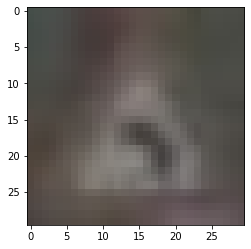

In [ ]:
img1 = np.swapaxes(np.transpose(trainset.__getitem__(5)[0].detach().numpy()),0,1)
plt.imshow(img1)
trainset.__getitem__(5)[1]

We created dataloaders to make our datasets iterables.


In [ ]:
batch_size = 130
# Wrap into the data loader
train_loader = torch.utils.data.DataLoader(dataset=trainset,
                                           batch_size=batch_size,
                                           shuffle=True)
 
test_loader = torch.utils.data.DataLoader(dataset=testset,
                                          batch_size=batch_size,
                                          shuffle=False)


## Neural network implementation

Design a dynamic model class to make it modular

In [ ]:
num_classes = 43
input_size = 69120

class SignClassification(nn.Module):
    def __init__(self,nb_epochs , num_classes, number_of_hidden_layers, layer_width , activation_func, Dropout_value):
        super(SignClassification, self).__init__()
        layers = []
        layers.append(nn.Linear(1372, layer_width))
        layers.append(activation_func)
        for i in range(0, number_of_hidden_layers):
          layers.append(nn.Linear(layer_width, layer_width))
          layers.append(activation_func)
          if i == (number_of_hidden_layers -2):
              layers.append(nn.Dropout(Dropout_value))
        
        layers.append(nn.Linear(layer_width, num_classes))

 
        self.c1 = nn.Sequential(
            nn.Conv2d(3, 5, kernel_size=2, stride=1, padding=1),
            nn.BatchNorm2d(5),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2, stride=1, padding = 1) 
        )
        
        
        self.c3 = nn.Sequential(
            nn.Conv2d(5, 10, kernel_size=3, stride = 2, padding = 1),
            nn.BatchNorm2d(10),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.c5 = nn.Sequential(
            nn.Conv2d(10, 28, kernel_size=2),
            nn.BatchNorm2d(28),
            nn.ReLU()
        )
        self.c7 = nn.Sequential(
            nn.Conv2d(4, 7, kernel_size = 3, stride = 2, padding = 1),
            nn.BatchNorm2d(7),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 1)
        )
        
        self.layers = nn.Sequential(*layers)

 
    def forward(self, x):
        out = self.c1(x)
        out = self.c3(out)
        out = self.c5(out)
        #out = self.c7(out)
        out = out.reshape(out.size(0), -1)
        #out = self.fc1(out)
        out = self.layers(out)
        #out = self.fc2(out)
        return out



In [ ]:
net = SignClassification(nb_epochs= 5 , num_classes = 43, number_of_hidden_layers = 4, layer_width = 60, activation_func = nn.ReLU(), Dropout_value = 0.30).to(device)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.03, momentum=0.9)
for layer in net.children():
   if hasattr(layer, 'reset_parameters'):
       layer.reset_parameters()

In [ ]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


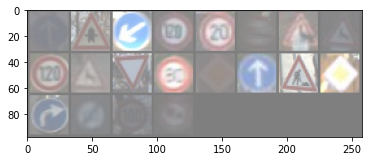

In [ ]:
for data in test_loader:
  img, lab = data
#


# print images
imshow(torchvision.utils.make_grid(img))


In [ ]:
images, labels = img.cuda(), lab.cuda()
outputs = net(images)

_, predicted = torch.max(outputs, 1)
print('GroundTruth: ', ' '.join(f'{CLASSES[labels[j]]:43s}' for j in range(4)))
print('Predicted: ', ' '.join(f'{CLASSES[predicted[j]]:43s}'
                              for j in range(4)))

GroundTruth:  00017                                       00023                                       00021                                       00001                                      
Predicted:  00008                                       00008                                       00008                                       00008                                      


In [ ]:
#Function to run the model :
nb_hidden_layers = 4
#nb_epochs =10
def run_model(nb_epochs  ,num_classes , number_of_hidden_layers  , layer_width, activation_func , Dropout_value): 
  #num_epochs = 5
  net = SignClassification(nb_epochs  ,num_classes = num_classes, number_of_hidden_layers = nb_hidden_layers, layer_width= layer_width, activation_func = activation_func, Dropout_value = Dropout_value).to(device)
  total_step = len(train_loader)
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.SGD(net.parameters(), lr=0.03, momentum=0.9)
  for layer in net.children():
    if hasattr(layer, 'reset_parameters'):
        layer.reset_parameters()
  for epoch in range(nb_epochs):  # loop over the dataset multiple times

      running_loss = 0.0
      for i, data in enumerate(train_loader, 0):
          # get the inputs; data is a list of [inputs, labels]
          inputs, labels = data
          inputs, labels = inputs.cuda(), labels.cuda()

          # zero the parameter gradients
          optimizer.zero_grad()

          # forward + backward + optimize
          outputs = net(inputs)
          loss = criterion(outputs, labels)
          loss.backward()
          optimizer.step()

          # print statistics
          running_loss += loss.item()
          if i % 49 == 0:    # print every 2000 mini-batches
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                    .format(epoch + 1, nb_epochs, i + 1, total_step, loss.item()))

  print('Finished Training')
  correct = 0
  total = 0
  pred_classes = []
  true_classes = []
  results = pd.DataFrame()
  # since we're not training, we don't need to calculate the gradients for our outputs
  with torch.no_grad():
      for data in test_loader:
          images, labels = data
          images, labels = images.cuda(), labels.cuda()

          # calculate outputs by running images through the network
          outputs = net(images)
          # the class with the highest energy is what we choose as prediction
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()
          pred_classes.append(list(np.array(torch.max(outputs.data,1)[1].cpu())))
          true_classes.append(list(np.array(labels.cpu())))
          
  results['Predicted Class'] = pred_classes
  results['True Classes'] = true_classes
  
  print(f'Accuracy of the network on the 12630 test images: {100 * correct // total} %')
  return results #(100*correct // total)



In [ ]:
epochs = 8
res =  run_model(nb_epochs = epochs, num_classes = 43, number_of_hidden_layers = 20, layer_width = 150, activation_func = nn.Tanh(), Dropout_value = 0.25)

Epoch [1/8], Step [1/205], Loss: 3.7597
Epoch [1/8], Step [50/205], Loss: 3.0578
Epoch [1/8], Step [99/205], Loss: 1.9029
Epoch [1/8], Step [148/205], Loss: 1.9718
Epoch [1/8], Step [197/205], Loss: 1.2675
Epoch [2/8], Step [1/205], Loss: 1.2280
Epoch [2/8], Step [50/205], Loss: 0.9330
Epoch [2/8], Step [99/205], Loss: 0.9221
Epoch [2/8], Step [148/205], Loss: 0.6355
Epoch [2/8], Step [197/205], Loss: 0.5433
Epoch [3/8], Step [1/205], Loss: 0.3476
Epoch [3/8], Step [50/205], Loss: 0.3307
Epoch [3/8], Step [99/205], Loss: 0.2422
Epoch [3/8], Step [148/205], Loss: 0.2220
Epoch [3/8], Step [197/205], Loss: 0.2694
Epoch [4/8], Step [1/205], Loss: 0.1245
Epoch [4/8], Step [50/205], Loss: 0.1606
Epoch [4/8], Step [99/205], Loss: 0.1115
Epoch [4/8], Step [148/205], Loss: 0.1777
Epoch [4/8], Step [197/205], Loss: 0.2607
Epoch [5/8], Step [1/205], Loss: 0.2845
Epoch [5/8], Step [50/205], Loss: 0.1755
Epoch [5/8], Step [99/205], Loss: 0.1066
Epoch [5/8], Step [148/205], Loss: 0.1257
Epoch [5/8],

The model has a pretty high accuracy on the test set

In [ ]:
res2 = pd.DataFrame()
res2['Predicted Class'] = res['Predicted Class'].explode()
res2['True Class'] = res['True Classes'].explode()
count = []
correct_val = []
for class_ in list(set(res2['True Class'])):
  count.append(len(res2[res2['True Class'] == class_]))
  correct_val.append(len(res2[(res2['True Class'] == class_) & (res2['True Class'] == res2['Predicted Class'])]))
x= np.arange(len(count))
res_df = pd.DataFrame(count, columns = ['Values per class'])
res_df['Accurately predicted value per class'] = correct_val

## Checking accuracy of the model


In this next part we'll see "how" missclassified our test data are

In [ ]:
res_df['number_of_missclassified'] = (res_df['Values per class']- res_df['Accurately predicted value per class']) #/  res_df['Values per class']) * 100
res_df['share_of_missclassified'] = (res_df['number_of_missclassified'] / res_df['Values per class'])


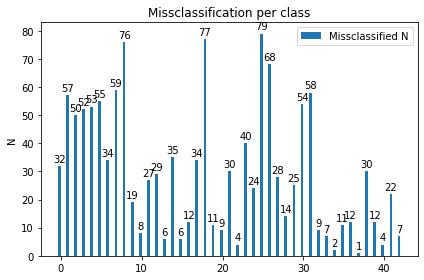

Global share of missclassified observation :  10  %


In [ ]:
width = 0.35  # the width of the bars

fig, ax = plt.subplots()

rects1 = ax.bar(x - width/2, res_df['number_of_missclassified'], width, label='Missclassified N')
#rects2 = ax.bar(x + width/2, correct_val, width, label='Accurately predicted')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('N')
ax.set_title('Missclassification per class')
#ax.set_xticks(x, x)
ax.legend()

ax.bar_label(rects1, padding=2)
#ax.bar_label(rects2, padding=3)
#plt.xticks(rotation = 60)

fig.tight_layout()

plt.show()
print("Global share of missclassified observation : ",round(sum(res_df['number_of_missclassified'] / len(res2))*100)," %")


In [ ]:
res_df.sort_values(by = 'share_of_missclassified', ascending = False)

,Values per class,Accurately predicted value per class,number_of_missclassified,share_of_missclassified
0,60,28,32,0.533333
27,60,32,28,0.466667
26,180,112,68,0.377778
41,60,38,22,0.366667
30,150,96,54,0.360000
21,90,60,30,0.333333
29,90,65,25,0.277778
24,90,66,24,0.266667
23,150,110,40,0.266667
6,150,116,34,0.226667


In [ ]:
pred_classes = [pred for sublist in res['Predicted Class'] for pred in sublist]
true_classes = [true for sublist in res['True Classes'] for true in sublist]

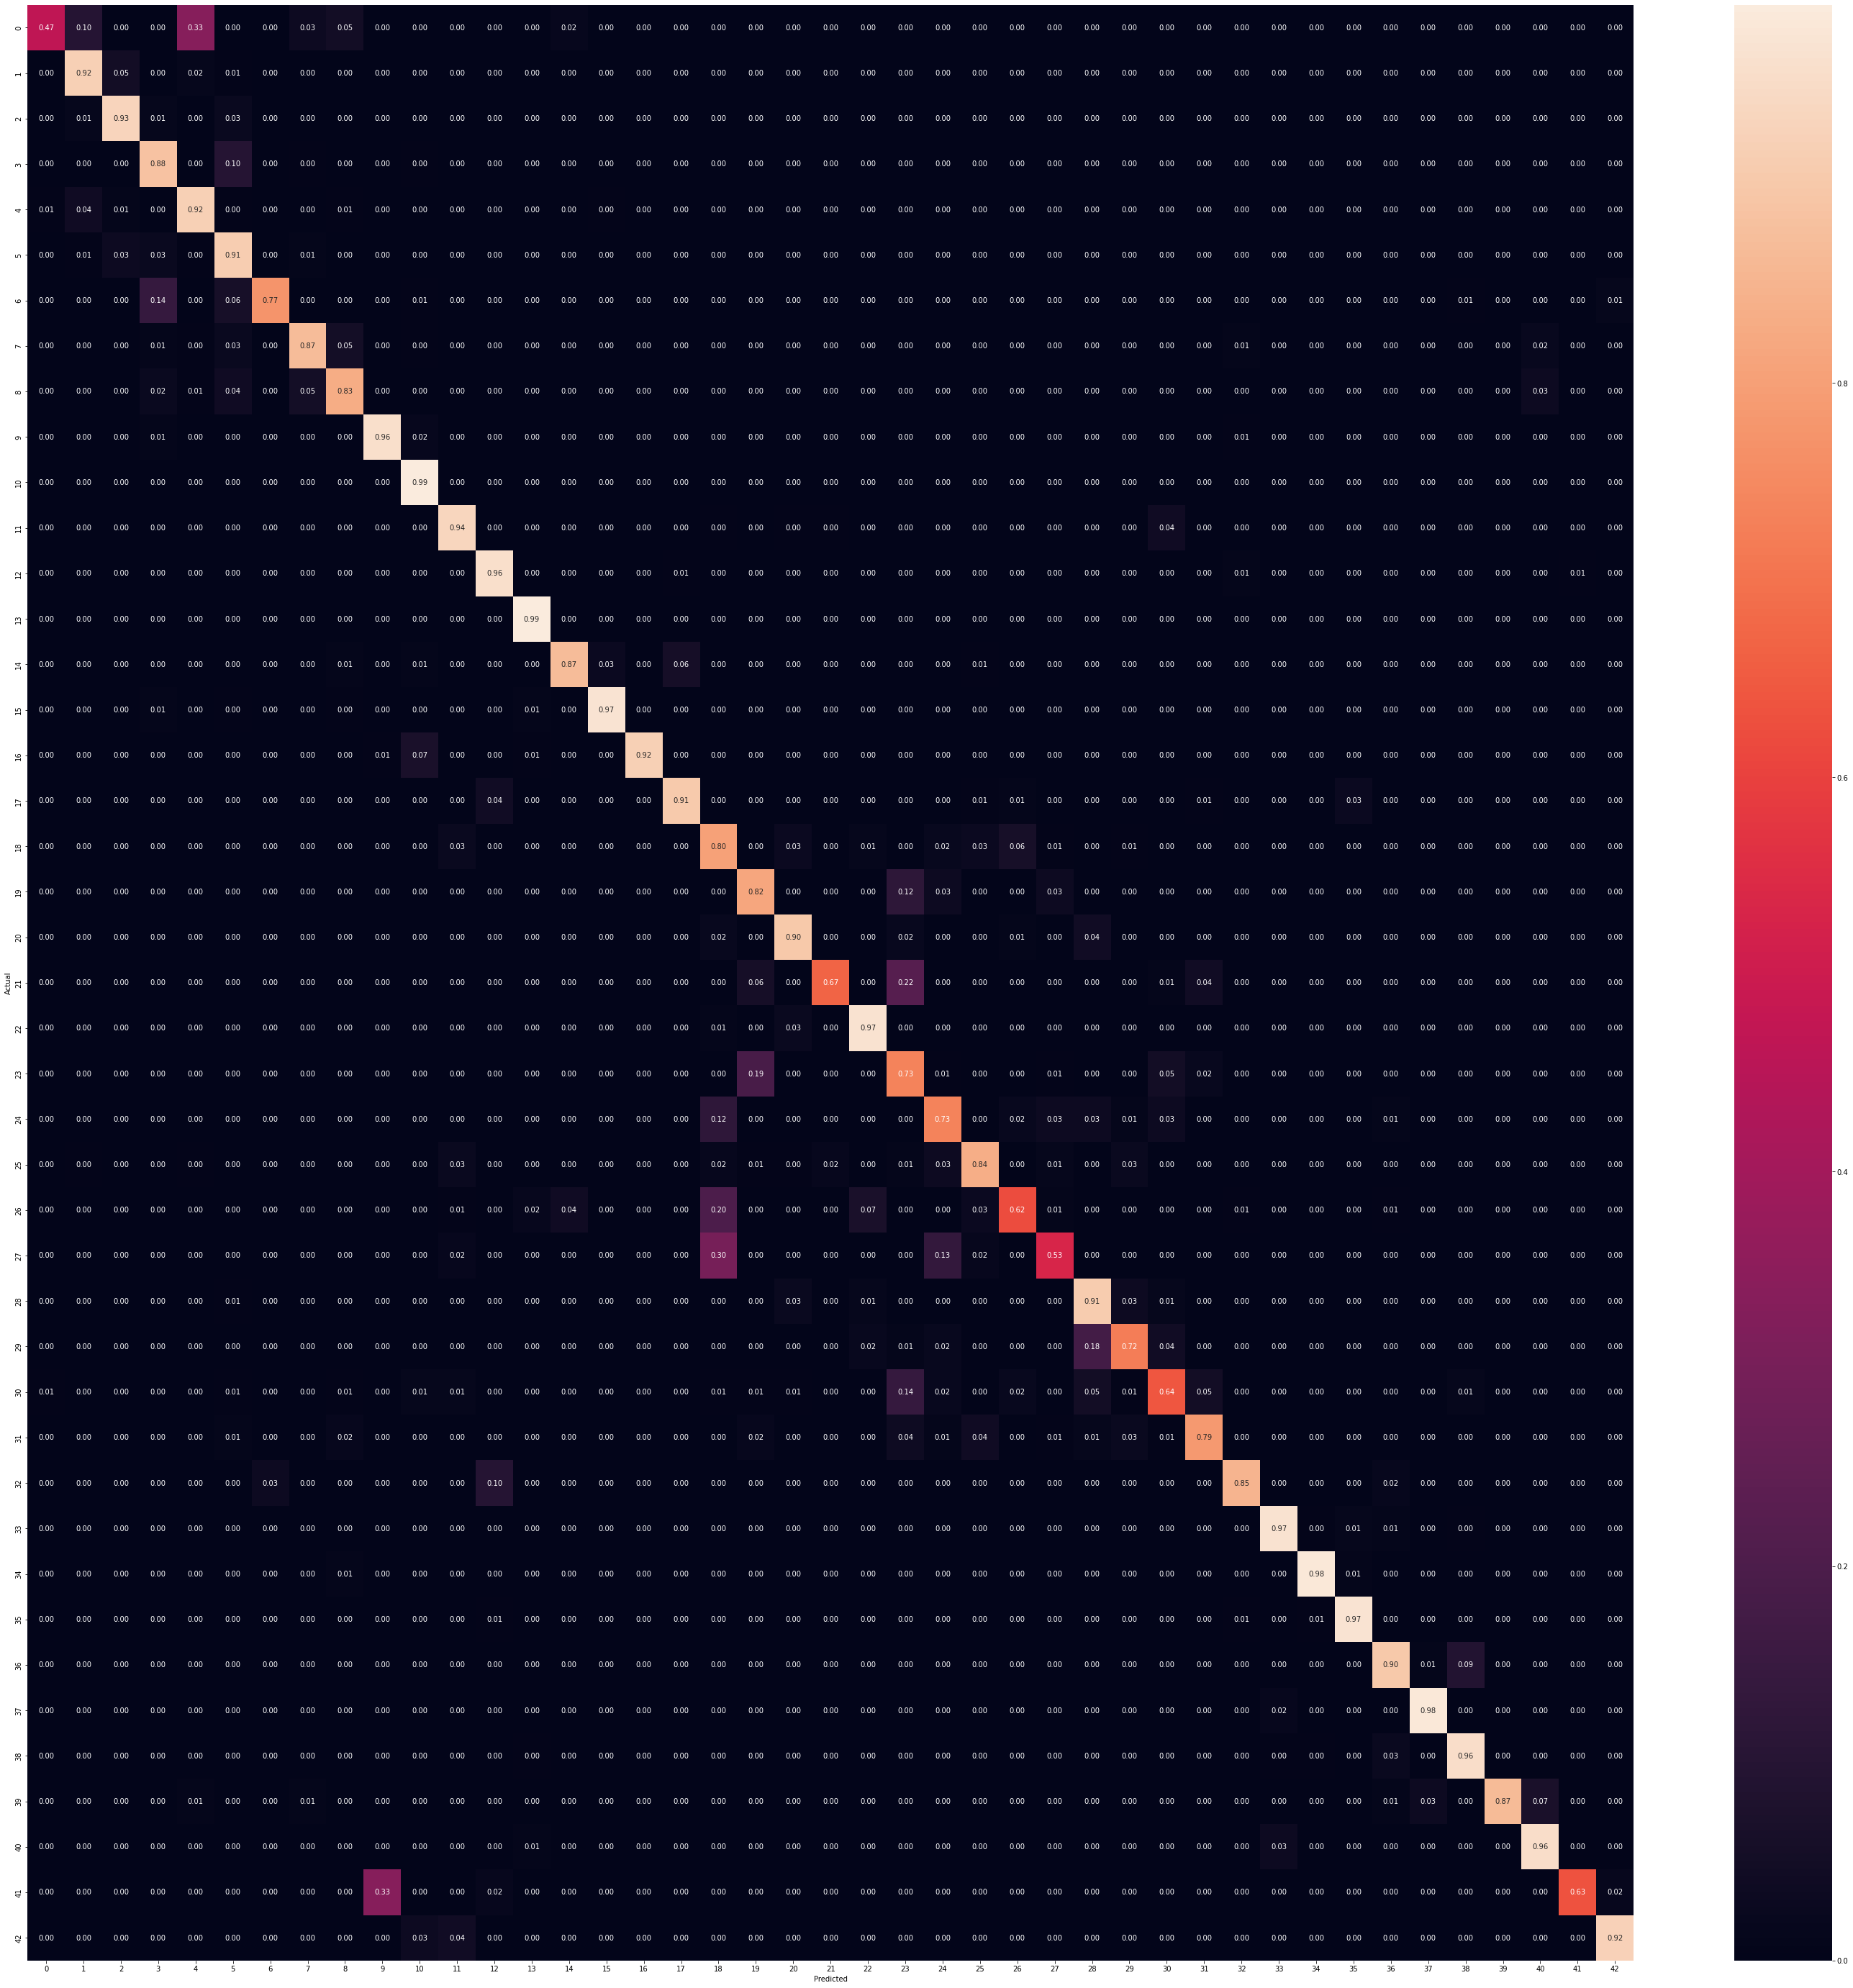

In [ ]:


target_names = range(43)
cm = confusion_matrix(true_classes,pred_classes)
# Normalise
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(50,50))
sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=target_names, yticklabels=target_names)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)

In [ ]:

from collections import Counter
 
def most_frequent(List):
    occurence_count = Counter(List)
    return occurence_count.most_common(1)[0][0]

In [ ]:
list(np.array(torch.max(outputs.data,1)[1].cpu()))
list(np.array(labels.cpu()))

[35, 11, 39, 8, 0, 10, 18, 31, 8, 31, 13, 5, 12, 35, 25, 12, 33, 6, 7, 10]

In [ ]:
'''accuracies_3l= []
accuracies_5l= []
accuracies_8l= []
accuracies_10l= []
accuracies_15l= []
hidden = 3
for width in [10,50,75,100,150,200]:
  #res =run_model(net = SignClassification(num_classes = 43, number_of_hidden_layers = hidden, layer_width = width, activation_func = nn.Tanh(), Dropout_value = 0.25).to(device))
  accuracies_3l.append(run_model(net = SignClassification(num_classes = 43, number_of_hidden_layers = 3, layer_width = width, activation_func = nn.Tanh(), Dropout_value = 0.25).to(device)))
  accuracies_5l.append(run_model(net = SignClassification(num_classes = 43, number_of_hidden_layers = 5, layer_width = width, activation_func = nn.Tanh(), Dropout_value = 0.25).to(device)))
  accuracies_8l.append(run_model(net = SignClassification(num_classes = 43, number_of_hidden_layers =8, layer_width = width, activation_func = nn.Tanh(), Dropout_value = 0.25).to(device)))
  accuracies_10l.append(run_model(net = SignClassification(num_classes = 43, number_of_hidden_layers = 10, layer_width = width, activation_func = nn.Tanh(), Dropout_value = 0.25).to(device)))
  accuracies_15l.append(run_model(net = SignClassification(num_classes = 43, number_of_hidden_layers = 15, layer_width = width, activation_func = nn.Tanh(), Dropout_value = 0.25).to(device)))'''

In [ ]:
plt.plot([10,50,75,100,150,200], accuracies_dropout)
plt.ylabel('Test set Accuracy')
plt.xlabel('Width of hidden layers (2 hidden layers)')
plt.axhline(y=max(accuracies_dropout), color='r', linestyle='-')
plt.axvline(x=[10,50,75,100,150,200][(np.argmax(accuracies_dropout))], color='r', linestyle='-')
plt.suptitle('Accuracy evolution / width of hidden layers, with Drop out')
plt.title('(2 hidden layers, activation = Tanh)')

Plot of models accuracy depending of number of hidden layers and width of hidden layers


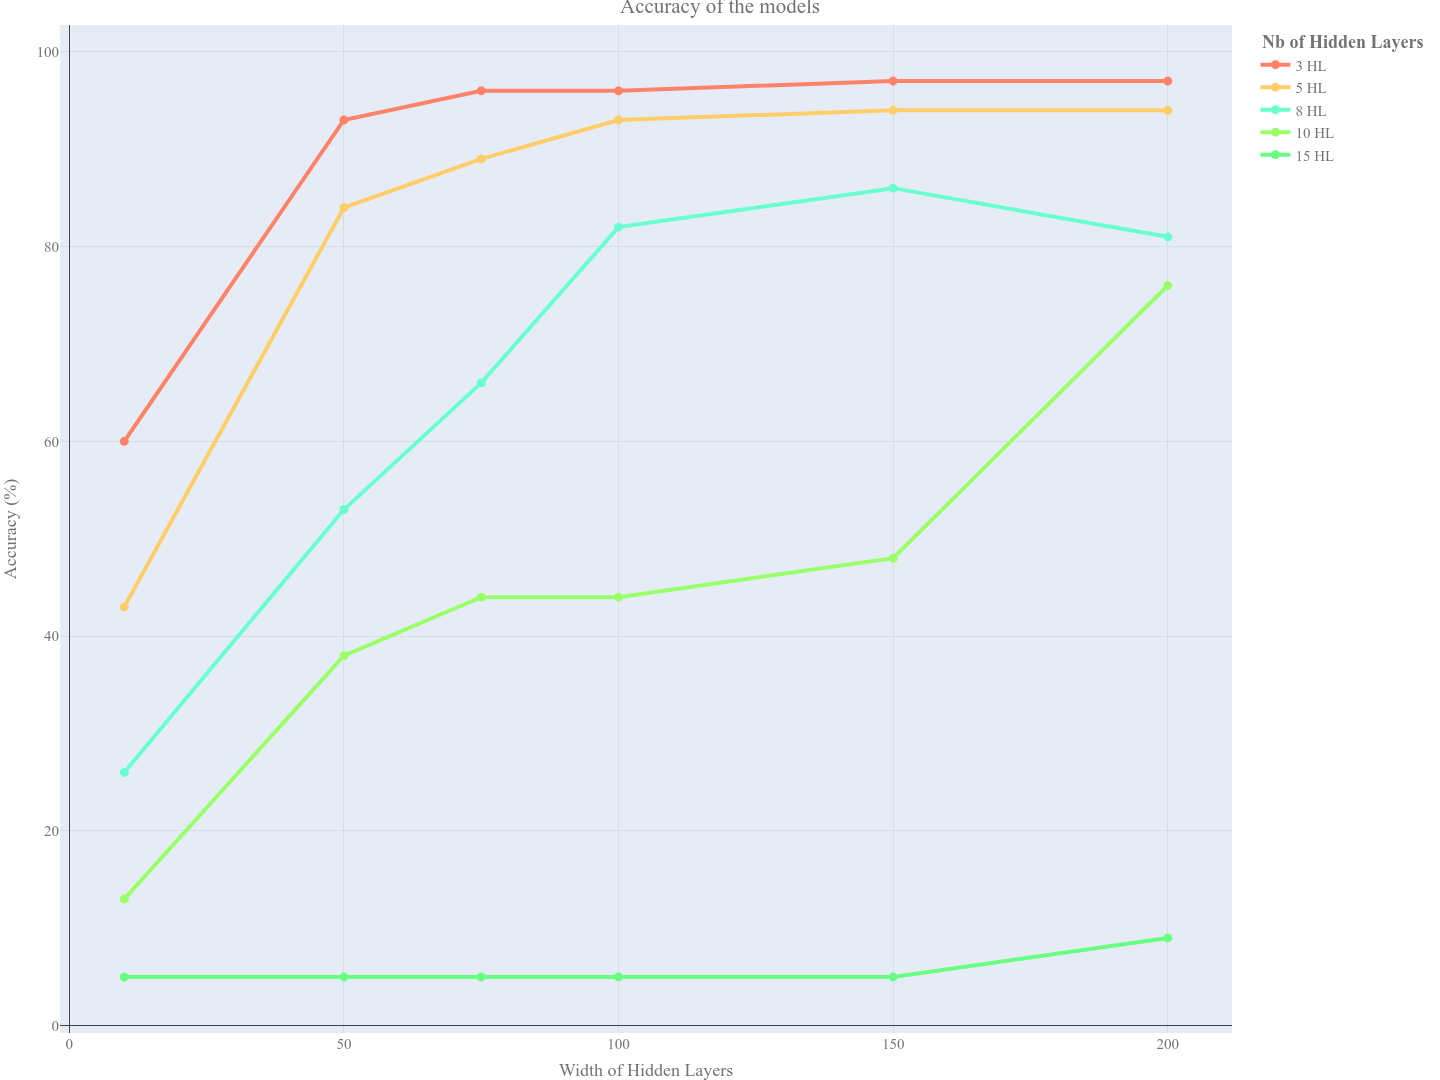

In [ ]:
from IPython.display import Image

Image('/content/drive/MyDrive/DL projet/accuracy.png', width=900, height=600)

In [ ]:
import plotly.express as px


fig = px.line(df, x="year", y="lifeExp", color='country')
fig.show()

Text(0.5, 1.0, '(2 hidden layers, activation = Tanh)')

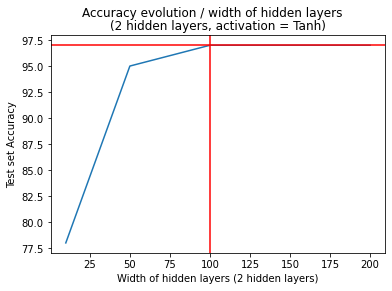

In [ ]:
plt.plot([10,50,75,100,150,200], accuracies)
plt.plot([10,50,75,100,150,200], accuracies_dropout)
plt.ylabel('Test set Accuracy')
plt.xlabel('Width of hidden layers (2 hidden layers)')
plt.axhline(y=max(accuracies), color='r', linestyle='-')
plt.axvline(x=[10,50,75,100,150,200][(np.argmax(accuracies))], color='r', linestyle='-')
plt.suptitle('Accuracy evolution / width of hidden layers')
plt.title('(2 hidden layers, activation = Tanh)')

Text(0.5, 1.0, '(2 hidden layers)')

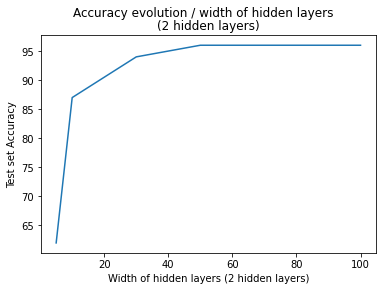

In [ ]:
plt.plot([5,10,30,50,100], accuracies)
plt.ylabel('Test set Accuracy')
plt.xlabel('Width of hidden layers (2 hidden layers)')
plt.suptitle('Accuracy evolution / width of hidden layers')
plt.title('(2 hidden layers)')

Text(0.5, 0, 'Number of Fully connected hidden layers')

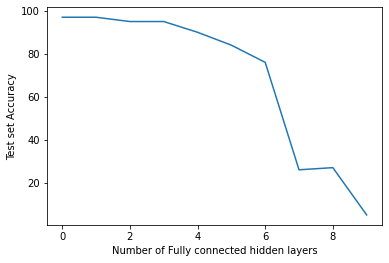

In [ ]:
accuracies
plt.plot(range(10), accuracies)
plt.ylabel('Test set Accuracy')
plt.xlabel('Number of Fully connected hidden layers')

In [ ]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images, labels = images.cuda(), labels.cuda()

        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 6660 test images: {100 * correct // total} %')

Accuracy of the network on the 6660 test images: 94 %


This final model accuracy come from our hand made test set (as a random share of our train set)